# Part II Wildtest the trained models

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import mxnet as mx 
import cv2
from data_ulti import get_iterator

In [8]:
def decodeBox(yolobox, size, dscale):
    i, j, cx, cy, w, h = yolobox
    cxt = j*dscale + cx*dscale
    cyt = i*dscale + cy*dscale
    wt = w*size
    ht = h*size
    return [cxt, cyt, wt, ht]


def bboxdraw(img, label, dscale=32):
    assert label.shape == (7,7,5)
    size = img.shape[1]
    ilist, jlist = np.where(label[:,:,0]>=0.3)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    for i,j in zip(ilist, jlist): 
        cx,cy,w,h = label[i,j,1:]
        cxt, cyt, wt ,ht = decodeBox([i, j, cx,cy,w,h], size, dscale)
        # Create a Rectangle patch
        rect = patches.Rectangle((cxt-wt/2,cyt-ht/2), wt,ht,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

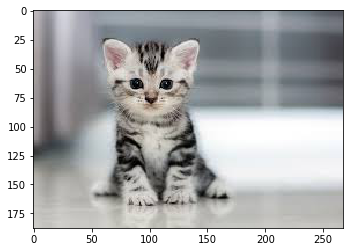

Original image


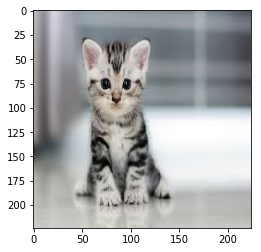

Resized image


In [9]:
# Read test image and transforms it into a rectange 
cat_test = plt.imread("cat_test.jpg")
plt.imshow(cat_test)
plt.show()
print "Original image"
# Define the width and height of the transformed image
W = 224
H = 224
# The opencv resize function can resize the image into 224X224
cat_resize = cv2.resize(cat_test,(W,H))
plt.imshow(cat_resize)
plt.show()
print "Resized image"

In [10]:
# Next we transform this image to the format that can be accepted by mxnet
# First of all, let us take a look at the image
print(cat_resize.shape)  # The shape of this cat is 224X224X3
cat_resize_mxnet = cat_resize.transpose((2,0,1)).reshape(1,3,H,W)
# Transform it into a mx.ndarray
cat_nd = mx.nd.array(ctx = mx.cpu(),source_array=cat_resize_mxnet)
# Generate the iterator
cat_itr = mx.io.NDArrayIter(data=cat_nd,data_name="data",batch_size = 1)
# Ask about the Iterator

(224, 224, 3)


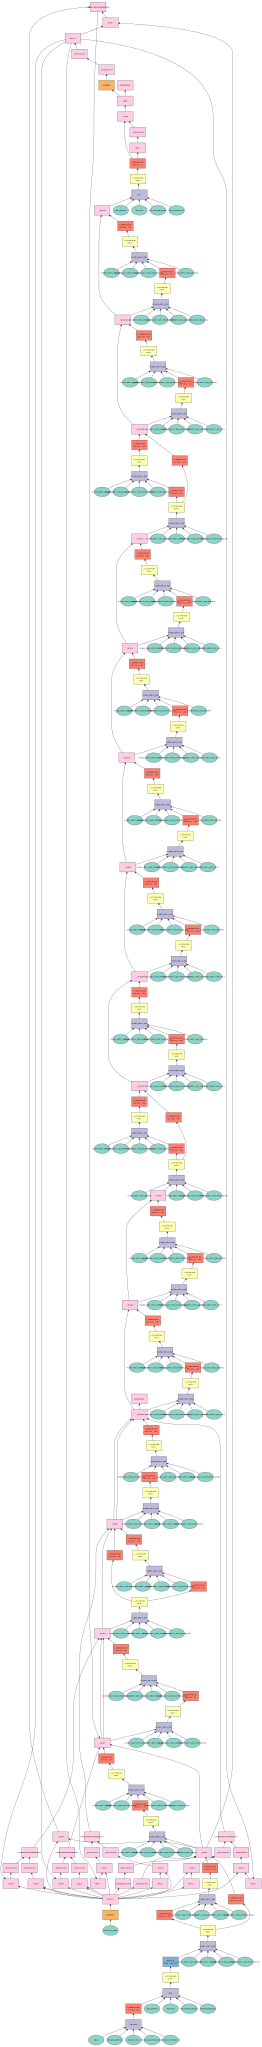

In [14]:
# Get the graph from the trained model
# The following will return the structure of the network to syms, trainning parameters (weights of nd tensor) to args_params 
# and some other parameters (batch normalizations) to aux_params
sym, args_params, aux_params = mx.model.load_checkpoint("models/cat_detect_full_scale",600)
# Retrieve the output layer

# Visualize the network
mx.viz.plot_network(sym,hide_weights=True,save_format='pdf',title='Pretrained model')

In [11]:

# Obtain the desired layer
logit = sym.get_internals()["logit_output"]
mod = mx.mod.Module(symbol = logit,context = mx.cpu())
mod.bind(cat_itr.provide_data)
mod.init_params(allow_missing=False,arg_params=args_params,aux_params=aux_params,
               initializer = mx.init.Xavier(magnitude=2,rnd_type="gaussian",factor_type="in"))
out = mod.predict(eval_data = cat_itr, num_batch=10)

In [12]:
pred = (out.asnumpy()[0]+1)/2
print pred.shape

(7, 7, 5)


Prediction


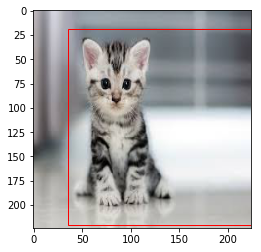

In [13]:
print "Prediction"
bboxdraw(cat_resize,pred)

In [64]:
args_params

{'bn0_beta': <NDArray 64 @cpu(0)>,
 'bn0_gamma': <NDArray 64 @cpu(0)>,
 'bn1_beta': <NDArray 512 @cpu(0)>,
 'bn1_gamma': <NDArray 512 @cpu(0)>,
 'bn_data_beta': <NDArray 3 @cpu(0)>,
 'bn_data_gamma': <NDArray 3 @cpu(0)>,
 'conv0_weight': <NDArray 64x3x7x7 @cpu(0)>,
 'convolution0_weight': <NDArray 5x512x3x3 @cpu(0)>,
 'stage1_unit1_bn1_beta': <NDArray 64 @cpu(0)>,
 'stage1_unit1_bn1_gamma': <NDArray 64 @cpu(0)>,
 'stage1_unit1_bn2_beta': <NDArray 64 @cpu(0)>,
 'stage1_unit1_bn2_gamma': <NDArray 64 @cpu(0)>,
 'stage1_unit1_conv1_weight': <NDArray 64x64x3x3 @cpu(0)>,
 'stage1_unit1_conv2_weight': <NDArray 64x64x3x3 @cpu(0)>,
 'stage1_unit1_sc_weight': <NDArray 64x64x1x1 @cpu(0)>,
 'stage1_unit2_bn1_beta': <NDArray 64 @cpu(0)>,
 'stage1_unit2_bn1_gamma': <NDArray 64 @cpu(0)>,
 'stage1_unit2_bn2_beta': <NDArray 64 @cpu(0)>,
 'stage1_unit2_bn2_gamma': <NDArray 64 @cpu(0)>,
 'stage1_unit2_conv1_weight': <NDArray 64x64x3x3 @cpu(0)>,
 'stage1_unit2_conv2_weight': <NDArray 64x64x3x3 @cpu(0)>,
 

In [71]:
print(sym.get_internals()["logit_output"])

<Symbol logit>


In [69]:
a = mx.sym.var('a')
b = mx.sym.var('b')
c = a + b
d = c.get_internals()
d["a"]

<Symbol a>

In [72]:
help(mx.mod.Module)

Help on class Module in module mxnet.module.module:

class Module(mxnet.module.base_module.BaseModule)
 |  Module is a basic module that wrap a `Symbol`. It is functionally the same
 |  as the `FeedForward` model, except under the module API.
 |  
 |  Parameters
 |  ----------
 |  symbol : Symbol
 |  data_names : list of str
 |      Defaults to `('data')` for a typical model used in image classification.
 |  label_names : list of str
 |      Defaults to `('softmax_label')` for a typical model used in image
 |      classification.
 |  logger : Logger
 |      Defaults to `logging`.
 |  context : Context or list of Context
 |      Defaults to ``mx.cpu()``.
 |  work_load_list : list of number
 |      Default ``None``, indicating uniform workload.
 |  fixed_param_names: list of str
 |      Default ``None``, indicating no network parameters are fixed.
 |  state_names : list of str
 |      states are similar to data and label, but not provided by data iterator.
 |      Instead they are initia